In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import time
import sys

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [2]:
DATA_DIR = "processed_celeba_small/"
MODEL_CHECKPOINT_LOCATION = "saved_models/"
TRAINING_LOGS_LOCATION = "logs/"
IMAGE_OUTPUT_PATH = "output/"

In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    
print(device)

cuda


In [4]:
def get_dataloader(batch_size, image_size, data_dir=DATA_DIR):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transformer = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir,transformer)
    data_loader = torch.utils.data.DataLoader(dataset,batch_size= batch_size, shuffle = True)
    
    return data_loader

#=================================================
# Convert image tensor to numpy and display it
#=================================================
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    
#=================================================
# Put normalized image into given feature range
#=================================================
def scale(x, feature_range=(-1,1)):
    min,max = feature_range
    x = (max-min)*x + min
    return x

In [5]:
#=================================================
# Discriminator Module
#=================================================
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels= out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)


class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.conv1 = conv(3,conv_dim,4,batch_norm=False)
        self.conv2 = conv(conv_dim,conv_dim*2,4,batch_norm=True)
        self.conv3 = conv(conv_dim*2,conv_dim*4,4,batch_norm=True)
        self.conv4 = conv(conv_dim*4,conv_dim*8,4,batch_norm=True)
        self.fc1 = nn.Linear(conv_dim*8*2*2,1)
        self.dropout1 = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.conv2(x),0.2)
        x = F.leaky_relu(self.conv3(x),0.2)
        x = F.leaky_relu(self.conv4(x),0.2)
        x = self.dropout1(x)
        x = x.view(-1,self.conv_dim*8*2*2)
        x = self.fc1(x)
        return x


#=================================================
# Generator Module
#=================================================

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    trans_conv_layer = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    # append conv layer
    layers.append(trans_conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)



class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fc1 = nn.Linear(z_size,conv_dim*8*2*2)
        self.conv1 = deconv(conv_dim*8,conv_dim*4,4,batch_norm=True)
        self.conv2 = deconv(conv_dim*4,conv_dim*2,4,batch_norm=True)
        self.conv3 = deconv(conv_dim*2,conv_dim,4,batch_norm=True)
        self.conv4 = deconv(conv_dim,3,4,batch_norm=False)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        x = self.fc1(x)
        x = x.view(-1,self.conv_dim*8,2,2)
        x = F.relu(self.conv1(x))
        x = self.dropout2(x)
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = F.relu(self.conv3(x))
        x = self.dropout2(x)
        x = torch.tanh(self.conv4(x))
        
        return x

In [6]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, mean=0, std=0.02)

In [7]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [8]:
#=====================================================
# Calculating real and fake loss
#=====================================================
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size).to(device)
        
    criterion = nn.BCEWithLogitsLoss()

        
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size).to(device)
        
    criterion = nn.BCEWithLogitsLoss()

        
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [9]:
def train(D, G, d_optimizer, g_optimizer, train_loader, start_epoch = 1, end_epoch = 1, print_every=100):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    D.to(device)
    G.to(device)
    
    #log training time
    start_time = time.time()
    
    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    
    len_train_loader = len(train_loader)

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)

    
    f = open(TRAINING_LOGS_LOCATION+"training_log.txt",'w')
    
    
    # epoch training loop
    for epoch in range(start_epoch, end_epoch+1):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images).to(device)
            
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            d_real_out = D(real_images)
            d_real_loss = real_loss(d_real_out)
            
            fake_images = G(fixed_z)
            d_fake_out = D(fake_images)
            
            d_fake_loss = fake_loss(d_fake_out)
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            fake_images = G(fixed_z)
            g_out = D(fake_images)
            
            g_loss = real_loss(g_out)
            g_loss.backward()
            g_optimizer.step()
                        
            
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                
                stats = 'Epoch [%d/%d], Step: [%d/%d], \t D_Loss: %.5f, G_Loss: %.5f, Time (mins): %.3f' % (epoch, end_epoch, batch_i, len_train_loader,  d_loss.item(), g_loss.item(), (time.time()-start_time)/60)
                # print discriminator and generator loss
                #print('\r' + stats, end="")
                print(stats)

                sys.stdout.flush()
                f.write(stats + '\n')
                f.flush()
                
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        
        #print('\r' + stats)
        save_checkpoint(G,MODEL_CHECKPOINT_LOCATION+'generator_'+str(epoch)+".pth")
        save_checkpoint(D,MODEL_CHECKPOINT_LOCATION+'discriminator_'+str(epoch)+".pth")

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    f.close()
    print("============================================================================")
    print("Total Training Time (hours): "+str((time.time()-start_time)/3600))
    print("============================================================================")
        
    return D, G, losses

def save_checkpoint(model,fileLocation):
    torch.save(model.state_dict(),fileLocation)

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

Min:  tensor(-0.9059)
Max:  tensor(0.8118)


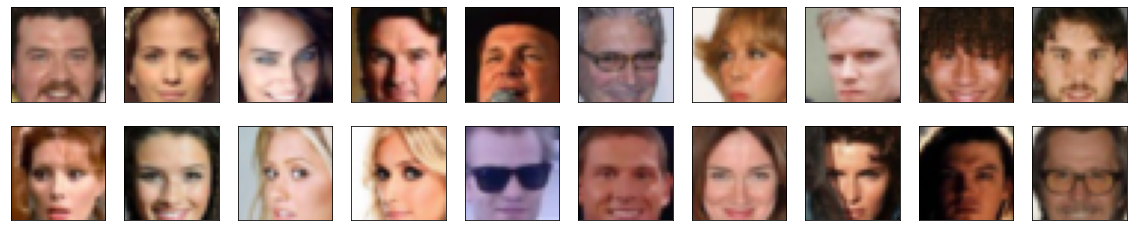

In [14]:
batch_size = 64
img_size = 32


# Create train loader
train_loader = get_dataloader(batch_size,img_size)

# Display some train samples
images, _ = iter(train_loader).next()

fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

    
# Test scale
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

In [10]:
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

beta1 = 0.2
beta2 = 0.09

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

d_optimizer = optim.Adam(D.parameters(), 0.0005, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), 0.0005, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=1024, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=1024, bias=True)
  (conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4)

In [16]:
start_epoch = 1
end_epoch = 100
print_every = 400

D, G, losses = train(D, G, d_optimizer, g_optimizer, 
               train_loader, 
               start_epoch = start_epoch, end_epoch = end_epoch, 
               print_every = print_every)

Epoch [1/100], Step: [0/1406], 	 D_Loss: 1.62923, G_Loss: 1.48748, Time (mins): 0.003
Epoch [1/100], Step: [400/1406], 	 D_Loss: 0.82422, G_Loss: 1.34349, Time (mins): 0.286
Epoch [1/100], Step: [800/1406], 	 D_Loss: 0.48212, G_Loss: 2.92239, Time (mins): 0.570
Epoch [1/100], Step: [1200/1406], 	 D_Loss: 0.48418, G_Loss: 2.57673, Time (mins): 0.851
Epoch [2/100], Step: [0/1406], 	 D_Loss: 0.65324, G_Loss: 1.03611, Time (mins): 0.996
Epoch [2/100], Step: [400/1406], 	 D_Loss: 1.05166, G_Loss: 4.03367, Time (mins): 1.273
Epoch [2/100], Step: [800/1406], 	 D_Loss: 0.19524, G_Loss: 5.81593, Time (mins): 1.551
Epoch [2/100], Step: [1200/1406], 	 D_Loss: 0.34252, G_Loss: 2.19171, Time (mins): 1.835
Epoch [3/100], Step: [0/1406], 	 D_Loss: 0.60448, G_Loss: 3.11102, Time (mins): 1.982
Epoch [3/100], Step: [400/1406], 	 D_Loss: 0.42410, G_Loss: 8.68229, Time (mins): 2.259
Epoch [3/100], Step: [800/1406], 	 D_Loss: 0.74379, G_Loss: 4.23086, Time (mins): 2.536
Epoch [3/100], Step: [1200/1406], 	 

In [11]:
def plot_logs(fileLocation):
    """
    Takes file location for log txt file and plots loss curve per 500 intervals
    """
    d_loss = []
    g_loss = []
    step = []
    
    with open(fileLocation, "r") as f:
        myLogs = f.readlines()
        interval = 4
        count = 1
        for line in myLogs:
            if(count%interval == 0):
                d_loss.append(float(line.split(",")[2].strip().split(" ")[1]))
                g_loss.append(float(line.split(",")[3].strip().split(" ")[1]))
                step.append(count)
                
            count += 1
    
    
    fig, axs = plt.subplots(2, figsize=(15,10))
    fig.suptitle('Training Logs')
    axs[0].set_title("Discriminator Loss")
    axs[1].set_title("Generator ")
    
    axs[0].plot(step, d_loss, color="g",marker=".")
    axs[1].plot(step, g_loss, color="m",marker=".")
    plt.show()
    
    print(d_loss[:10])
    print(g_loss[:10])
    

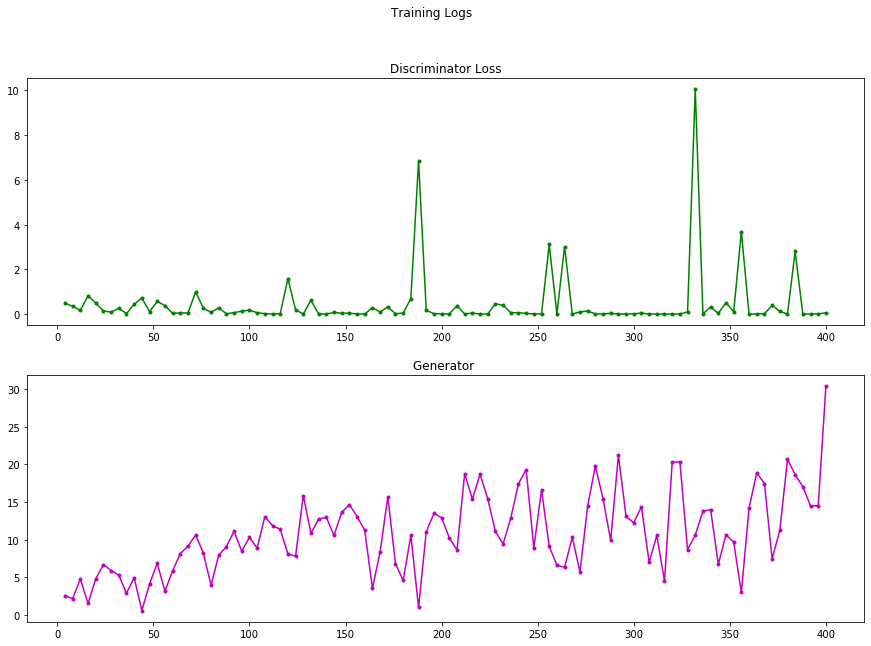

[0.48418, 0.34252, 0.16894, 0.80955, 0.49538, 0.13739, 0.08844, 0.25555, 0.02154, 0.43713]
[2.57673, 2.19171, 4.81245, 1.5491, 4.81656, 6.71653, 5.9118, 5.29794, 2.90125, 4.9683]


In [30]:
plot_logs(TRAINING_LOGS_LOCATION+"training_log.txt")

In [12]:
# Load state dict from any of the checkpoints to generate new images

D.load_state_dict(torch.load(MODEL_CHECKPOINT_LOCATION+'discriminator_2.pth'))
G.load_state_dict(torch.load(MODEL_CHECKPOINT_LOCATION+'generator_2.pth'))

<All keys matched successfully>

In [13]:
def generate_DCGAN_Images(D,G, num_images = 16):
    D.eval()
    G.eval()
    
    sample_size = num_images
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)
        
    result = G(fixed_z)
    print(result.size())

    #==========================================================
    # Save the generated image files and also return the list 
    #==========================================================
    fileList = []
    imageList = []
    for i in range(result.size(0)):
        filename_start = str(time.time())

        image = result[i].detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = ((image + 1)*255 / (2)).astype(np.uint8)
        image = image.reshape((32,32,3))

        dpi = 80
        figsize = (image.shape[1]/dpi, image.shape[0]/dpi)
        fig = plt.figure(figsize = figsize)
        ax = fig.add_axes([0,0,1,1])
        ax.axis('off')
        ax.imshow(image)

        output_file_name = IMAGE_OUTPUT_PATH+filename_start+"_"+str(i)+'.jpg'
        fig.savefig(output_file_name,dpi=dpi,transparent=True)
        fileList.append(output_file_name)
        
        plt.close(fig)
        
        imageList.append(image)

    return fileList, imageList
    

In [14]:
fileList, result = generate_DCGAN_Images(D,G, num_images = 10)

torch.Size([10, 3, 32, 32])


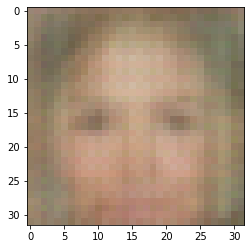

In [15]:
plt.imshow(result[0])

In [20]:
print(fileList)

['output/1609689617.8505044_0.jpg', 'output/1609689617.8710802_1.jpg', 'output/1609689617.8828926_2.jpg', 'output/1609689617.8960388_3.jpg', 'output/1609689617.969398_4.jpg', 'output/1609689617.9820404_5.jpg', 'output/1609689617.9940927_6.jpg', 'output/1609689618.0063372_7.jpg', 'output/1609689618.0182002_8.jpg', 'output/1609689618.0301368_9.jpg']
